In [43]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Importing useful libraries
import numpy as np
import os
import copy
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1 Breast Cancer Wisconsin Dataset

## 1.1 Loading the dataset 

In [44]:
from sklearn.datasets import load_breast_cancer

# Load as a sklearn bunch object
breast_cancer = load_breast_cancer()

# Convert to dataframe
cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
cancer['target'] = pd.Series(breast_cancer.target)

In [45]:
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 1.2 Investigating the Data

### 1.2.1 Feature Selection

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

When investigating if some features can be dropped due to a linear relationship, it is common to plot a scatter matrix that plots each feature against each other feature. However, in this dataset which contains 30 features, that would require 30^2 (900) plots. This is an unrealistic number to plot, display and sort through.

Therefore, the heatmap function from the seaborn library was used to plot a correlation matrix. The correlation value between a pair of features measures the degree of the linear relationship that they have. If the two features have a high correlation score (approaching 1) it means that they are linear and measure the same variable.

Therefore, by examining the heatmap, we can spot and eliminate any features that have a high correlation.

<Axes: >

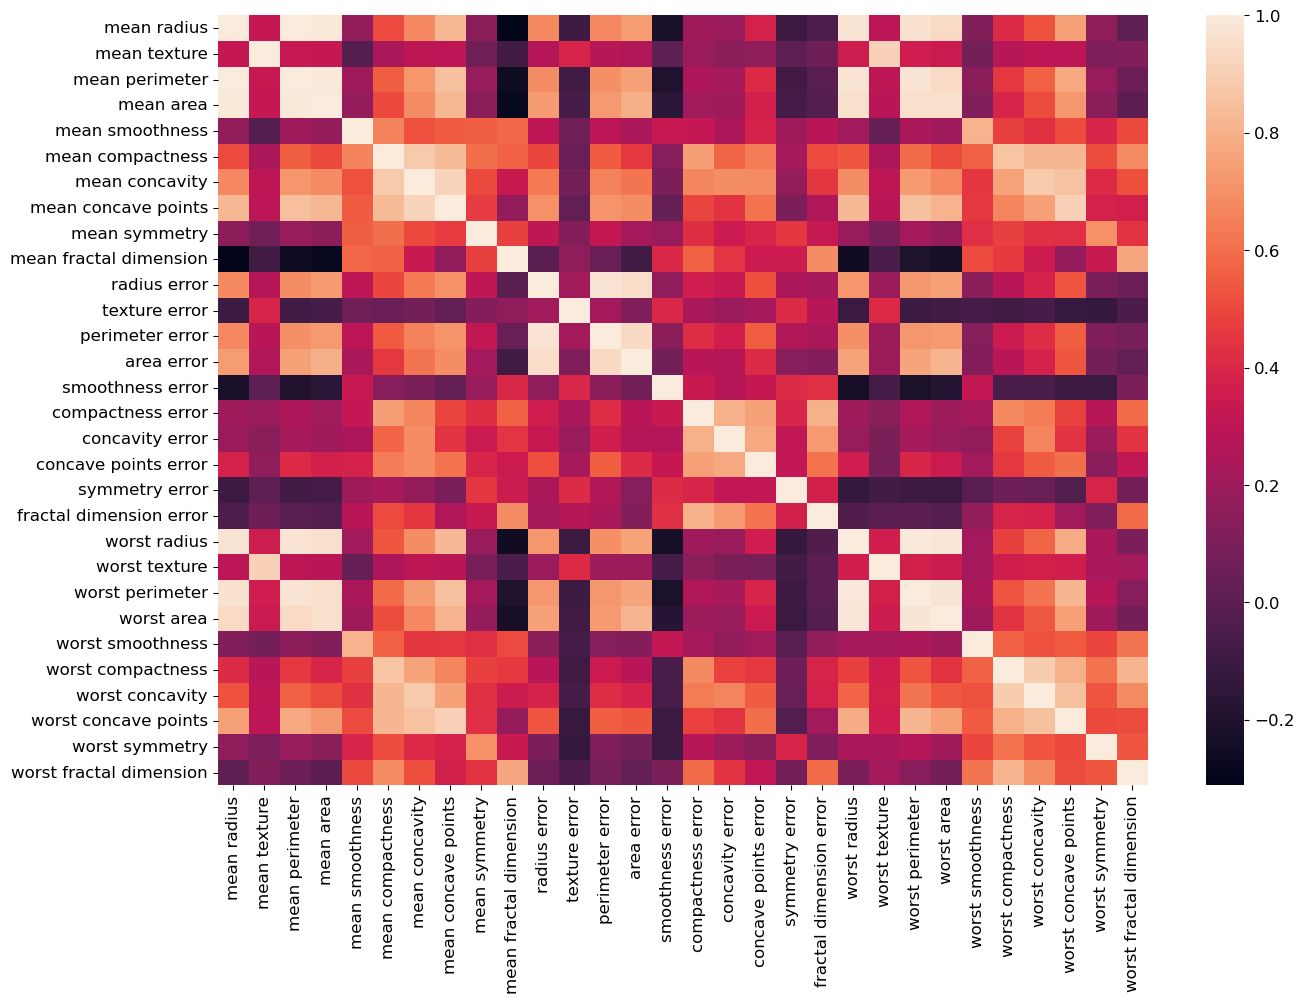

In [47]:
plt.figure(figsize=(15, 10))
sns.heatmap(cancer_copy.corr())

The following plot shows a scatter matrix for some of the variables that were eliminated. They have a high correlation value as per the correlation matrix above. Plotting them against each other on a scatter matrix demonstrates that variables that have a high correlation do indeed have a linear relationship. 

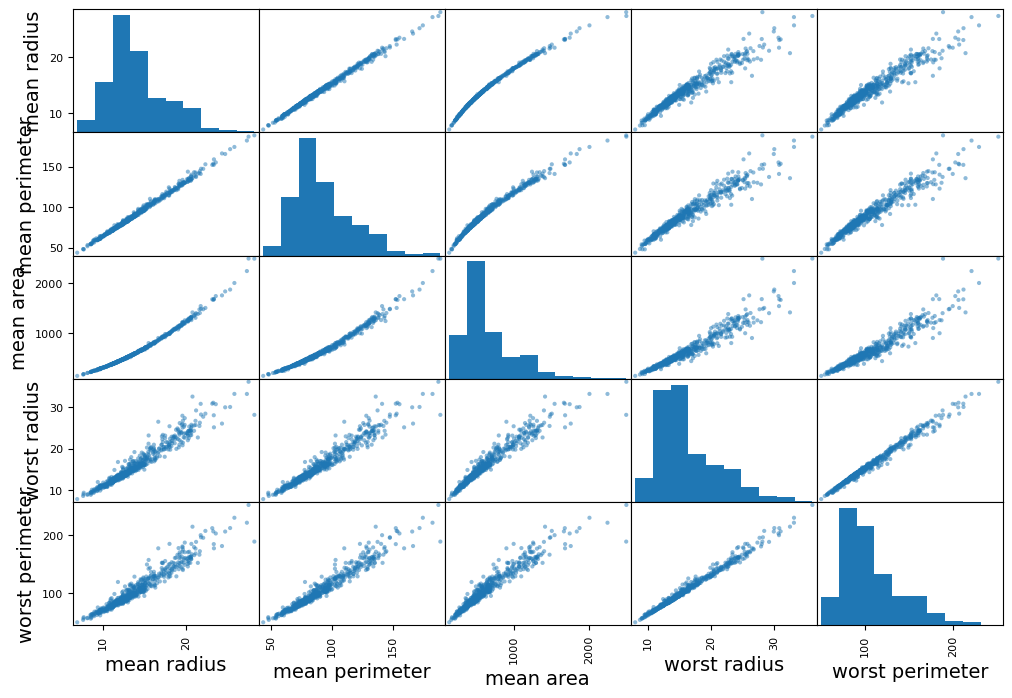

In [48]:
from pandas.plotting import scatter_matrix

attributes = ['mean radius', 'mean perimeter', 'mean area', 'worst radius', 'worst perimeter']

scatter_matrix(cancer[attributes], figsize=(12,8))
plt.show()

In [49]:
cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

# Dropping 15 features
features_drop = ['mean perimeter', 'mean area', 'worst radius', 'worst perimeter', 'worst area', 
                 'worst texture', 'worst concave points', 'worst concavity', 'worst compactness', 'perimeter error',
                'area error', 'mean concave points', 'mean concavity', 'worst smoothness', 'compactness error',]

for feature in features_drop:
    cancer_copy.drop(feature, axis=1, inplace=True)


<Axes: >

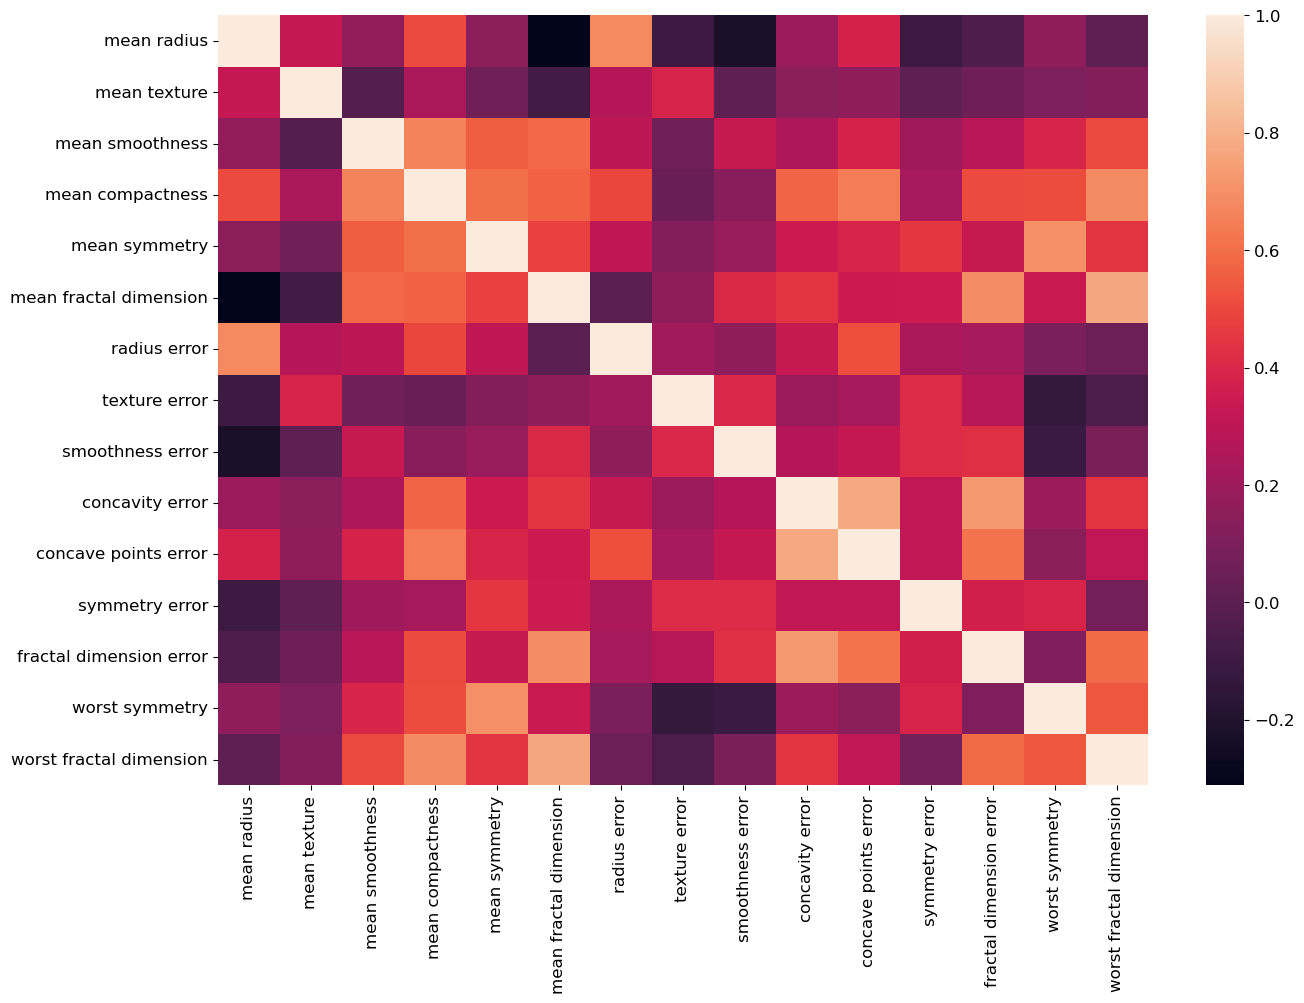

In [50]:
plt.figure(figsize=(15, 10))
sns.heatmap(cancer_copy.corr())

### 1.3.1 Preparing the training and test sets

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
cancer_train_X, cancer_test_X, cancer_train_y, cancer_test_y = train_test_split(cancer_copy, cancer['target'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func = StandardScaler()

cancer_train_X = scaler_func.fit_transform(cancer_train_X)
cancer_test_X = scaler_func.transform(cancer_test_X)

## 1.3 Decision Trees

### 1.3.1 Default Hyperparameters

The following cells will involve training a decision tree classifier on the selected features using the default hyperparameters.

It can be seen from the accuracy scores of 1 on the training set and 0.89 on the test set that the classifier has an overfitting issue. It can be seen from the perfect accuracy score on the training set that the model has fit very closely to the training data. However, given the fact that the accuracy drops to 0.89 on the test set suggests that the model is not performing as well on new, unseen data. This is a sign of overfitting. 

The classification report also gives insight into the performance of the classifier by providing the precision and recall scores. The model's precision dropped from 1 to 0.89 and recall dropped from 1 to 0.89 when moving from training data to test data. This suggests that the model is making more false positive and false negative predictions when presented with new data. This is another sign of overfitting

In [52]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

tree_default = DecisionTreeClassifier()
tree_default.fit(cancer_train_X, cancer_train_y)

y_pred_train_default = tree_default.predict(cancer_train_X)
accuracy_train_default = accuracy_score(cancer_train_y, y_pred_train_default)
report_train_default = classification_report(cancer_train_y, y_pred_train_default)

y_pred_test_default = tree_default.predict(cancer_test_X)
accuracy_test_default = accuracy_score(cancer_test_y, y_pred_test_default)
report_test_default = classification_report(cancer_test_y, y_pred_test_default)

print('The accuracy on the training set:', accuracy_train_default)
print('\n', report_train_default)
print('The accuracy on the testing set:', accuracy_test_default)
print('\n', report_test_default)

The accuracy on the training set: 1.0

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       307

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483

The accuracy on the testing set: 0.8953488372093024

               precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.90      0.92      0.91        50

    accuracy                           0.90        86
   macro avg       0.89      0.89      0.89        86
weighted avg       0.90      0.90      0.90        86



***IDK what to talk about here tbh***

In [58]:
# import graphviz
# from sklearn.tree import export_graphviz

# tree_default = DecisionTreeClassifier(max_depth=3)
# tree_default.fit(cancer_train_X, cancer_train_y)

# dot_data = tree.export_graphviz(tree_default, out_file=None, 
#                      feature_names=cancer_copy.columns,  
#                      class_names=['0', '1'],  
#                      filled=True, rounded=True,  
#                      special_characters=True)  

# graph = graphviz.Source(dot_data)  
# graph 

### 1.3.2 Restricting Depth to 3

The following cells will involve training a decision tree classifier on the selected features with max_depth=3 and the other hyperparameters set to their default values.

By setting max_depth=3, the classifier's performance has improved on both the training and testing sets. The accuracy on the training set is 0.95, which is lower than the previous score of 1. While this is a reduction in the accuracy as compared to before, this is a step in the positive direction. This suggests that the model is no longer overfitting as much to the training data.

On the test set, the accuracy has decreased slightly to 0.88, but the precision and recall scores have also improved to 0.89 and 0.87, respectively. This suggests that the model is performing well on new, unseen data and is able to generalize well beyond the training set.

In [57]:
tree_depth = DecisionTreeClassifier(max_depth=3)
tree_depth.fit(cancer_train_X, cancer_train_y)

y_pred_train_depth = tree_depth.predict(cancer_train_X)
accuracy_train_depth = accuracy_score(cancer_train_y, y_pred_train_depth)
report_train_depth = classification_report(cancer_train_y, y_pred_train_depth)

y_pred_test_depth = tree_depth.predict(cancer_test_X)
accuracy_test_depth = accuracy_score(cancer_test_y, y_pred_test_depth)
report_test_depth = classification_report(cancer_test_y, y_pred_test_depth)

print('The accuracy on the training set:', accuracy_train_depth)
print('\n', report_train_depth)
print('The accuracy on the testing set:', accuracy_test_depth)
print('\n', report_test_depth)

The accuracy on the training set: 0.9523809523809523

               precision    recall  f1-score   support

           0       0.97      0.90      0.93       176
           1       0.94      0.98      0.96       307

    accuracy                           0.95       483
   macro avg       0.96      0.94      0.95       483
weighted avg       0.95      0.95      0.95       483

The accuracy on the testing set: 0.8837209302325582

               precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.87      0.94      0.90        50

    accuracy                           0.88        86
   macro avg       0.89      0.87      0.88        86
weighted avg       0.89      0.88      0.88        86



### 1.3.3 Setting Min Samples Split  to 5

The following cells will involve training a decision tree classifier on the selected features with min_samples_split=5 and the other hyperparameters set to their default values.

The classifier's performance has improved significantly on both the training and testing sets. The accuracy on the training set is now 0.99, which suggests that the model is performing very well on the training data. The precision and recall scores on the training set have also improved to 1, which indicates that the model is perfectly identifying the positive cases in the training set. While this may look similar to the scores from section 1.3.1 where it was argued that accuracy, precision and recalls so close to being perfect on the training data are a sign of overfitting, further examination of the scores on the testing data reveals further insights. 

On the test set, the accuracy has improved to 0.90, which suggests that the model is able to generalize well beyond the training set. The precision and recall scores on the test set are both 0.89, which is also very good and suggests that the model is able to correctly identify positive cases with a low false positive rate and a low false negative rate.

The performance of this classifier suggests that tuning the min_samples_split hyperparameter is a good way to improve model performance.

In [55]:
tree_split = DecisionTreeClassifier(min_samples_split=5)
tree_split.fit(cancer_train_X, cancer_train_y)

y_pred_train_split = tree_split.predict(cancer_train_X)
accuracy_train_split = accuracy_score(cancer_train_y, y_pred_train_split)
report_train_split = classification_report(cancer_train_y, y_pred_train_split)

y_pred_test_split = tree_split.predict(cancer_test_X)
accuracy_test_split = accuracy_score(cancer_test_y, y_pred_test_split)
report_test_split = classification_report(cancer_test_y, y_pred_test_split)

print('The accuracy on the training set:', accuracy_train_split)
print('\n', report_train_split)
print('The accuracy on the testing set:', accuracy_test_split)
print('\n', report_test_split)

The accuracy on the training set: 0.9958592132505176

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       176
           1       1.00      1.00      1.00       307

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483

The accuracy on the testing set: 0.8953488372093024

               precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.90      0.92      0.91        50

    accuracy                           0.90        86
   macro avg       0.89      0.89      0.89        86
weighted avg       0.90      0.90      0.90        86



### 1.3.4 Setting Min Samples Leaf to 5

The following cells will involve training a decision tree classifier on the selected features with min_samples_leaf=5 and the other hyperparameters set to their default values.

On the test set, the accuracy has not improved significantly and remains at 0.88. The precision and recall scores on the test set are also 0.88, indicating that the model is performing consistently on both the training and testing sets.

Overall, the similar precision and recall scores on both the training and testing sets suggest that the model is not overfitting and is able to generalize well to new, unseen data. However, the relatively low accuracy on the testing set suggests that there is still room for improvement

In [59]:
tree_leaf = DecisionTreeClassifier(min_samples_leaf=5)
tree_leaf.fit(cancer_train_X, cancer_train_y)

y_pred_train_leaf = tree_leaf.predict(cancer_train_X)
accuracy_train_leaf = accuracy_score(cancer_train_y, y_pred_train_leaf)
report_train_leaf = classification_report(cancer_train_y, y_pred_train_leaf)

y_pred_test_leaf = tree_leaf.predict(cancer_test_X)
accuracy_test_leaf = accuracy_score(cancer_test_y, y_pred_test_leaf)
report_test_leaf = classification_report(cancer_test_y, y_pred_test_leaf)

print('The accuracy on the training set:', accuracy_train_leaf)
print('\n', report_train_leaf)
print('The accuracy on the testing set:', accuracy_test_leaf)
print('\n', report_test_leaf)

The accuracy on the training set: 0.9668737060041408

               precision    recall  f1-score   support

           0       0.95      0.95      0.95       176
           1       0.97      0.97      0.97       307

    accuracy                           0.97       483
   macro avg       0.96      0.96      0.96       483
weighted avg       0.97      0.97      0.97       483

The accuracy on the testing set: 0.8953488372093024

               precision    recall  f1-score   support

           0       0.91      0.83      0.87        36
           1       0.89      0.94      0.91        50

    accuracy                           0.90        86
   macro avg       0.90      0.89      0.89        86
weighted avg       0.90      0.90      0.89        86



## 1.4 Using Cross-Validation to find best hyperparameters

In [71]:
from sklearn.model_selection import GridSearchCV

# Create a new Decision Tree Classifier
tree = DecisionTreeClassifier()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=3, scoring='accuracy')
# Fit the grid search object to the training data
grid_search.fit(cancer_train_X, cancer_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}
Best cross-validation score: 0.917184265010352


## 1.5 Training Model on best Hyperparameters

In [70]:
tree_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=5)
tree_best.fit(cancer_train_X, cancer_train_y)

y_pred_train_best = tree_best.predict(cancer_train_X)
accuracy_train_best = accuracy_score(cancer_train_y, y_pred_train_best)

y_pred_test_best = tree_best.predict(cancer_test_X)
accuracy_test_best = accuracy_score(cancer_test_y, y_pred_test_best)

print('The accuracy on the training set:', accuracy_train_best)
print('The accuracy on the testing set:', accuracy_test_best)

The accuracy on the training set: 0.9668737060041408
The accuracy on the testing set: 0.872093023255814


## 1.6 Comparison

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(predictions, labels, y):
    # Create the figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Loop through each axis and plot the corresponding confusion matrix
    for i, ax in enumerate(axs.ravel()):
        if i < len(predictions):
            # Calculate the confusion matrix
            conf_matrix = confusion_matrix(y, predictions[i])

            # Plot the confusion matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
            disp.plot(ax=ax, cmap='Blues', values_format='.0f')
            disp.ax_.set_xlabel('Predicted Label')
            disp.ax_.set_ylabel('True Label')
            disp.ax_.set_title(labels[i])

    # Add some space between the plots and show the figure
    fig.tight_layout()
    fig.delaxes(axs[1][2])
    plt.show()

In [79]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(x, y, labels):
    classifiers = [tree_default, tree_depth, tree_split, tree_leaf, tree_best]
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    # Create the figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Loop through each classifier and plot its precision-recall curve on a separate plot
    for i, clf in enumerate(classifiers):
        # Calculate the precision-recall curve
        y_pred_proba = clf.predict_proba(x)[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_pred_proba)

        # Determine the subplot indices for this curve
        row = i // 2
        col = i % 2

        # Plot the precision-recall curve on the subplot
        ax = axs[col, row]
        ax.plot(recall, precision, color=colors[i])
        ax.set_title(labels[i])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')

    # Add some space between the plots and show the figure
    fig.tight_layout()
    fig.delaxes(axs[1][2])
    plt.show()

***TALK ABOUT FALSE POSITIVES***
- cancer screening
    - we want more false positives
    - we do not want false negatives

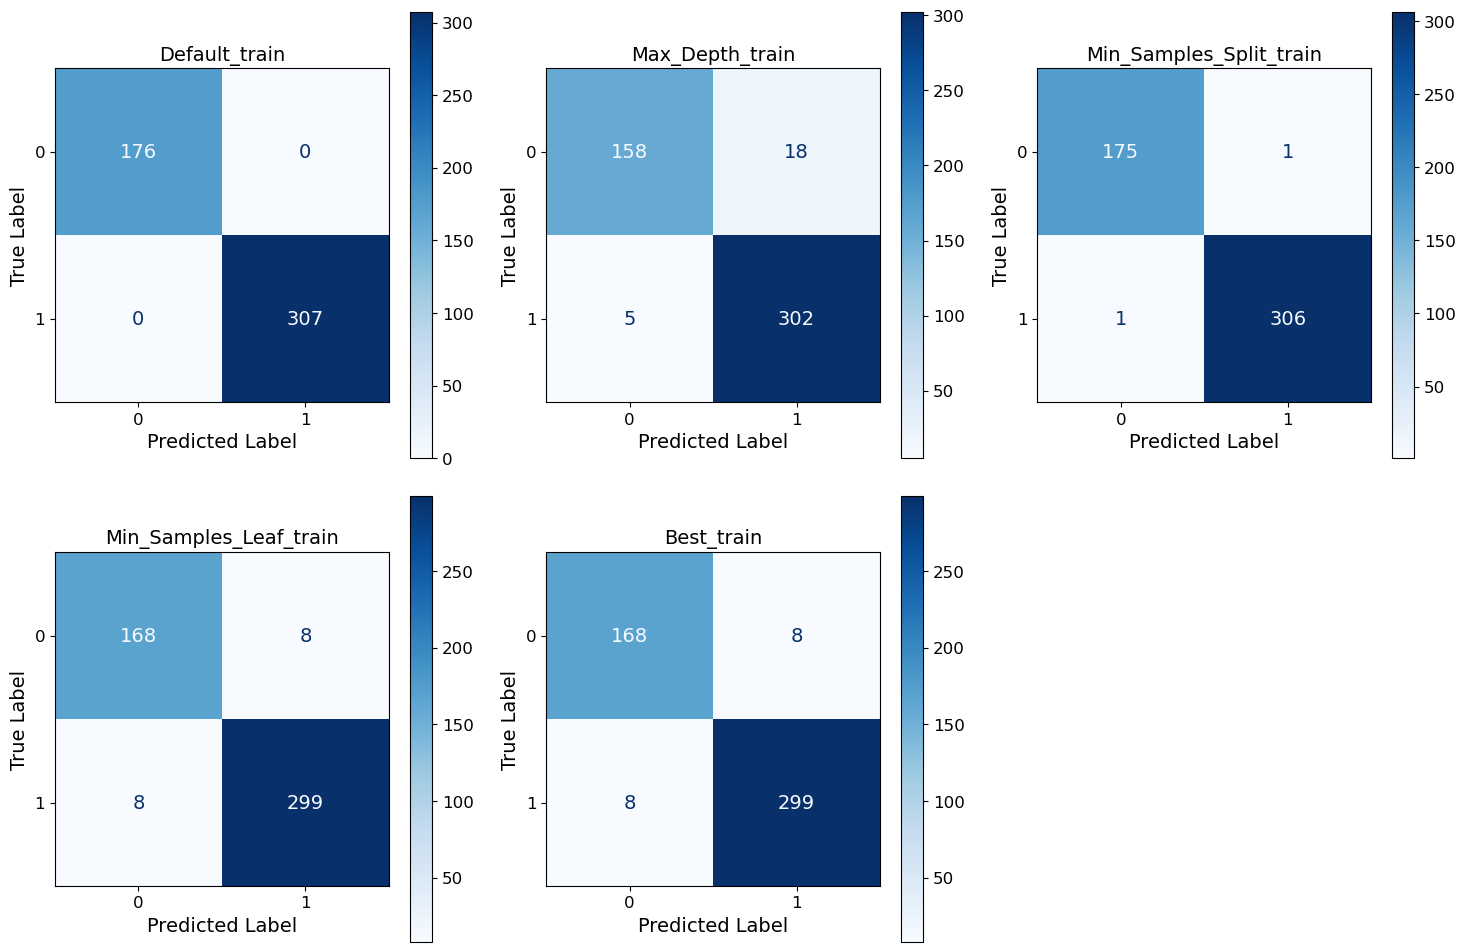

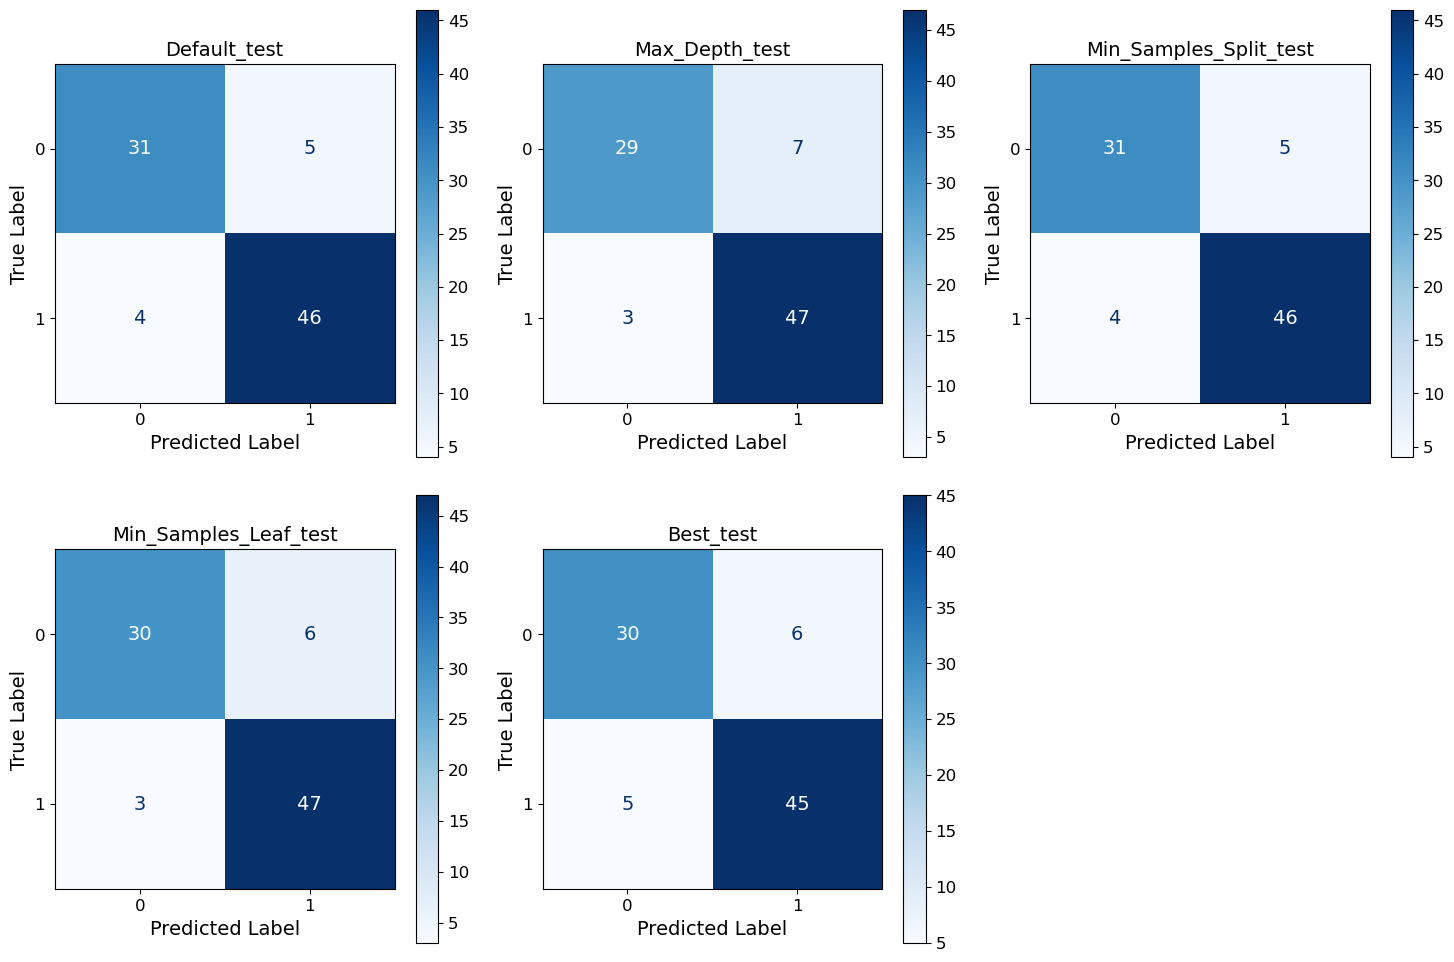

In [80]:
# Define your predictions
predictions_train = [y_pred_train_default, y_pred_train_depth, y_pred_train_split, y_pred_train_leaf, y_pred_train_best]
labels_train = ['Default_train', 'Max_Depth_train', 'Min_Samples_Split_train', 'Min_Samples_Leaf_train', 'Best_train']

predictions_test = [y_pred_test_default, y_pred_test_depth, y_pred_test_split, y_pred_test_leaf, y_pred_test_best]
labels_test = ['Default_test', 'Max_Depth_test', 'Min_Samples_Split_test', 'Min_Samples_Leaf_test', 'Best_test']

plot_confusion_matrix(predictions_train, labels_train, cancer_train_y)
plot_confusion_matrix(predictions_test, labels_test, cancer_test_y)

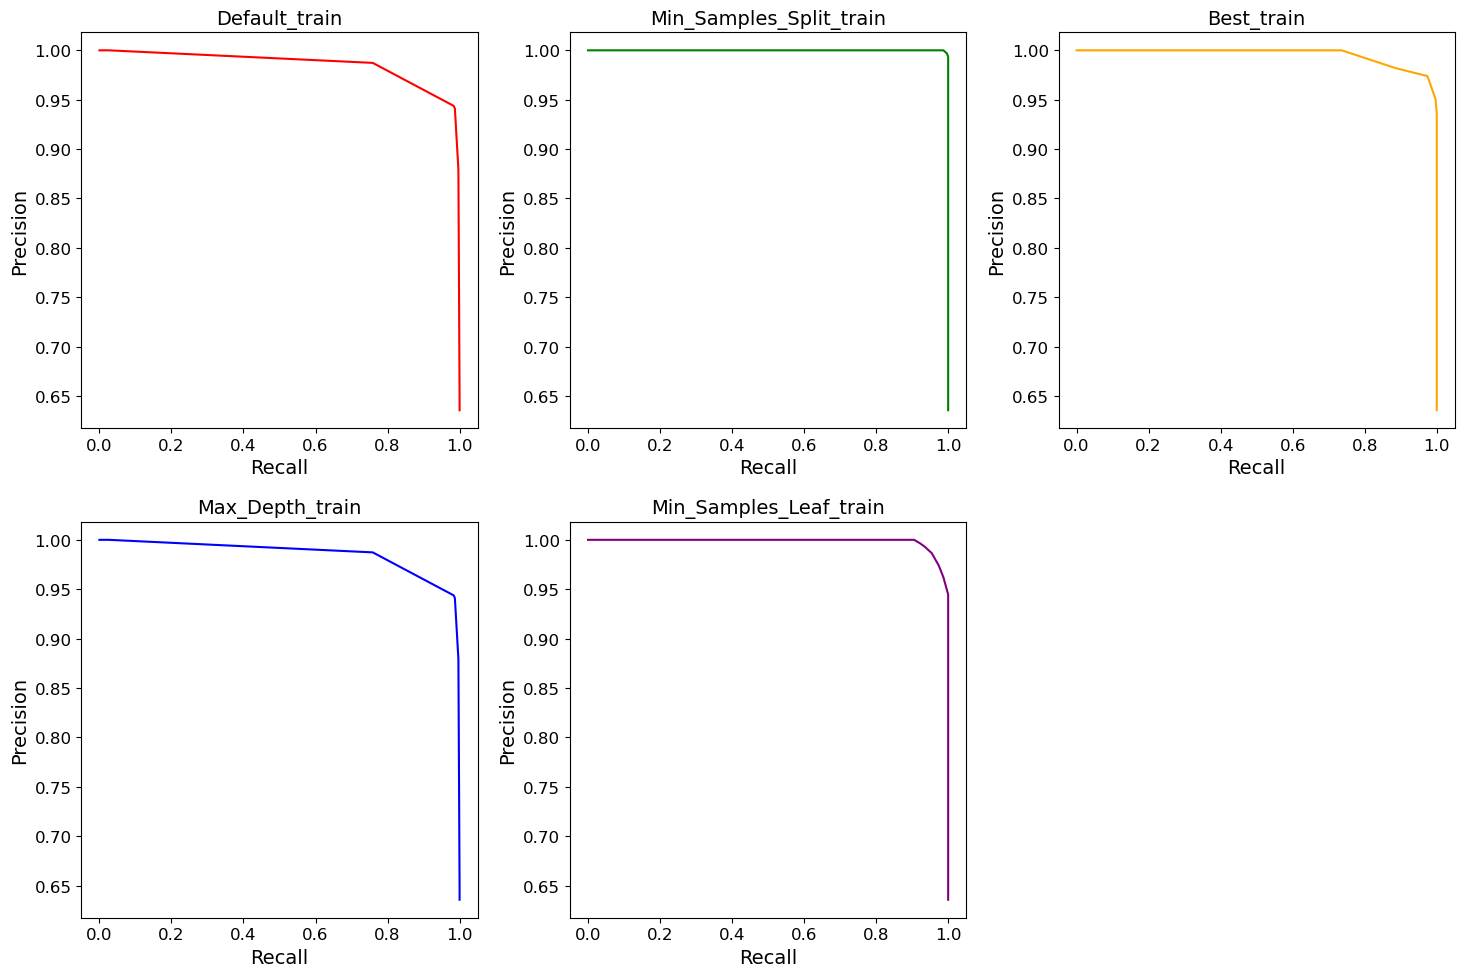

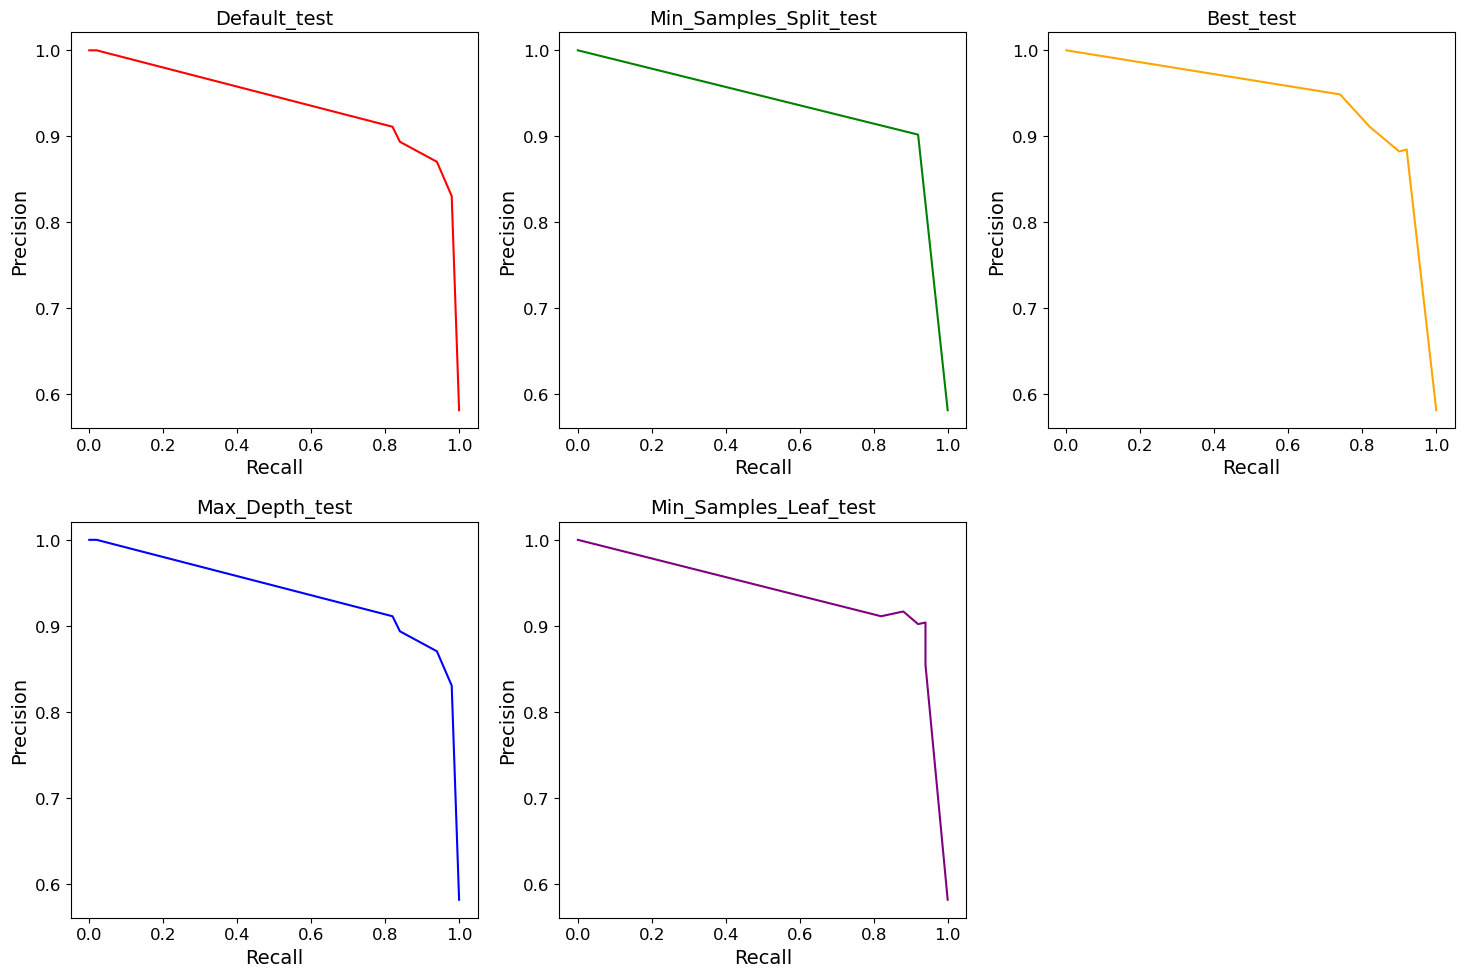

In [81]:
plot_precision_recall(cancer_train_X, cancer_train_y, labels_train)
plot_precision_recall(cancer_test_X, cancer_test_y, labels_test)

# 2 Concrete Slump Dataset

In [20]:
concrete_data = pd.read_csv('slump_test.data')
concrete_data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [21]:
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.0 KB

By inspection of the dataset, the 'No' column is an instance label which is not part of the classification task. Therefore, we will remove this along with the other two output columns. 

In [22]:
# Dropping the index col
concrete_data.drop('No', axis=1, inplace=True)
# Dropping the other 2 targets
concrete_data.drop('SLUMP(cm)', axis=1, inplace=True)
concrete_data.drop('FLOW(cm)', axis=1, inplace=True)

## 2.1 Visualizing the Data

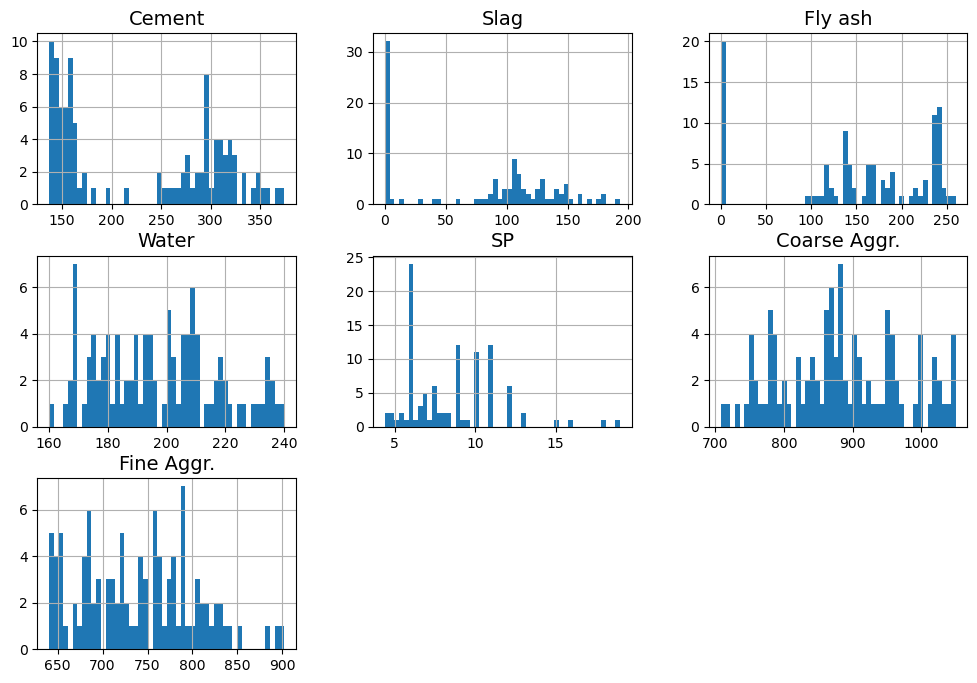

In [23]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

## 2.2 Splitting the Data

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Splitting the dataset into a training set (80%) and a testing set (20%) randomstate=123
con_train_X, con_test_X, con_train_y, con_test_y = train_test_split(concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1), concrete_data['Compressive Strength (28-day)(Mpa)'], test_size=0.20, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_1 = MinMaxScaler(feature_range=(0,1))

con_train_X = scaler_func.fit_transform(con_train_X)
con_test_X = scaler_func.transform(con_test_X)

#Transform back into a pd dataframe
feature_cols = ["Cement","Slag","Fly ash","Water","SP","Coarse Aggr.","Fine Aggr."]
con_train_X=pd.DataFrame(con_train_X, columns=feature_cols)
con_test_X=pd.DataFrame(con_test_X, columns=feature_cols)


## 2.3 Estimators with default parameters

In this section, a linear SVM regressor, linear regressor and a stochastic gradient descent regressor were trained using their default hyperparameters. A voting regressor based on the aforementioned three regressors was also trained using default parameters. 

In [25]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor

con_svr = SVR(kernel='linear')
con_lin = LinearRegression()
con_sgd = SGDRegressor()
con_voting = VotingRegressor([('Linear_SVR', con_svr), ('Linear-Reg', con_lin), ('SGD_Reg', con_sgd)])

con_lin.fit(con_train_X, con_train_y)
con_svr.fit(con_train_X, con_train_y)
con_sgd.fit(con_train_X, con_train_y)
con_voting.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR', SVR(kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor())])

### 2.3.1 Results and plots

In [26]:
from sklearn.metrics import mean_squared_error

def plot_con_predictions(regressors):
    rmse = []
    indexes = np.arange(0,21,1)

    plt.plot(indexes, con_test_y, label="GroundTruth")

    for reg in regressors:
        y_pred = reg.predict(con_test_X)
        rmse_val = np.sqrt(mean_squared_error(con_test_y, y_pred))
        rmse.append(rmse_val)
        plt.plot(indexes, y_pred, label=reg.__class__.__name__)
        print("RMSE value for {} regressor is: {}".format(reg.__class__.__name__, rmse_val))

    plt.legend(loc='best', fontsize=8)
    plt.xlabel("Index", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.title("Predict Values", fontsize=15)
    plt.show()
    
    return rmse

In [27]:
def plot_con_bars(rmse):
    labels = ['Linear_SVR', 'Linear-Reg', 'SGD_Reg', 'Voting_Reg']

    colors = ['b', 'g', 'r', 'y']

    fig, ax = plt.subplots()

    # create a bar chart with labels, rmse values, and colors
    ax.bar(labels, rmse, color=colors)

    # add the truncated rmse values on top of each bar
    for i, v in enumerate(rmse):
        ax.text(i, v + 0.1, str(round(v, 5)), ha='center', fontsize=10)

    # set the title and axis labels
    ax.set_title('RMSE Values')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')

    # display the plot
    plt.show()

RMSE value for SVR regressor is: 2.9104631777060246
RMSE value for LinearRegression regressor is: 3.2938784151981375
RMSE value for SGDRegressor regressor is: 3.173132260268054
RMSE value for VotingRegressor regressor is: 3.1218622748319995


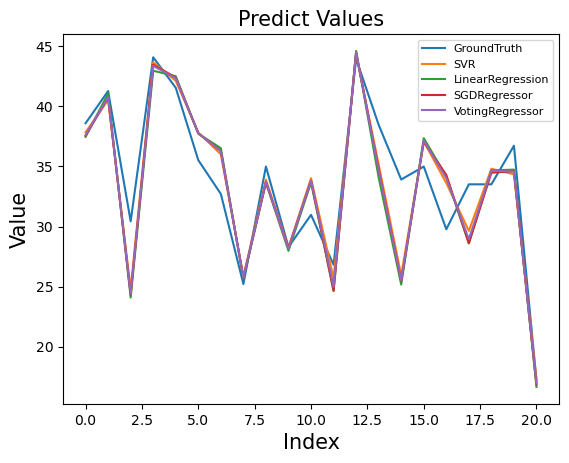

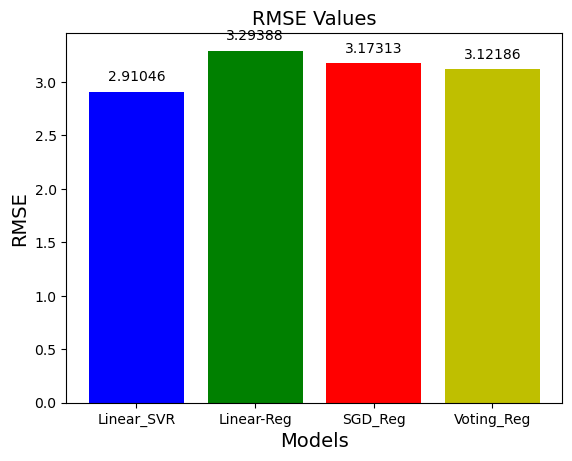

In [28]:
regressors = [con_svr, con_lin, con_sgd, con_voting]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

## 2.4 Tuning Hyperparameters

### 2.4.1 Linear SVR Regressor

In [29]:
svr = SVR(kernel='linear')

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'C': 10, 'epsilon': 1}
Best cross-validation score: -2.529991601729001


### 2.4.2 SGD Regressor

In [30]:
sgd = SGDRegressor()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'alpha': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(sgd, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 1e-08}
Best cross-validation score: -2.6573090531466654


### 2.4.3 Estimators with tuned parameters

- Overfitting 
- Cross validation done on the training set in hopes of better performance on the test set 
- Something went wrong and we start overfitting

- Voting regressor
    - Ensenble 
    - Reduce variance but increases bias.
    - Do some research on this 
    - hmm

In [31]:
con_svr_tuned = SVR(kernel='linear', C=10, epsilon=1)
con_lin_tuned = LinearRegression()
con_sgd_tuned = SGDRegressor(alpha=0.0000001)
con_voting_tuned = VotingRegressor([('Linear_SVR', con_svr_tuned), ('Linear-Reg', con_lin_tuned), ('SGD_Reg', con_sgd_tuned)])

con_lin_tuned.fit(con_train_X, con_train_y)
con_svr_tuned.fit(con_train_X, con_train_y)
con_sgd_tuned.fit(con_train_X, con_train_y)
con_voting_tuned.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR',
                             SVR(C=10, epsilon=1, kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor(alpha=1e-07))])

RMSE value for SVR regressor is: 3.5007749804403128
RMSE value for LinearRegression regressor is: 3.2938784151981375
RMSE value for SGDRegressor regressor is: 3.1929182558247073
RMSE value for VotingRegressor regressor is: 3.31560641915202


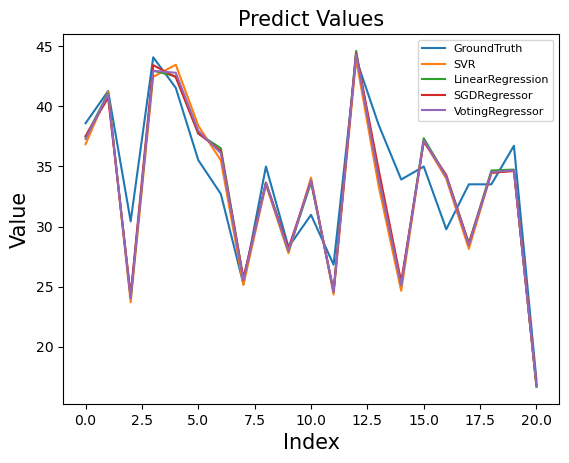

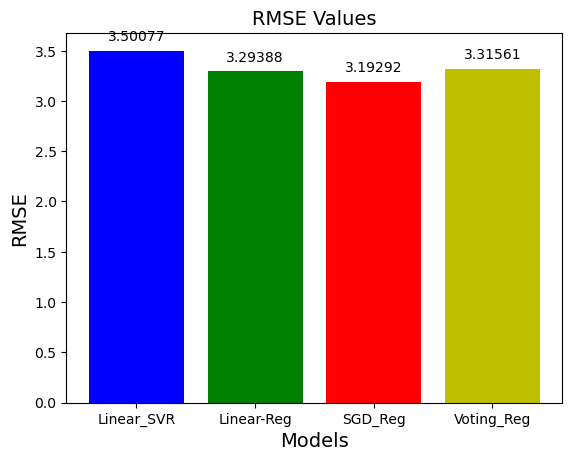

In [32]:
regressors = [con_svr_tuned, con_lin_tuned, con_sgd_tuned, con_voting_tuned]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

# 3 Abalone Dataset

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Read in data
ab_data = pd.read_csv('abalone.data')
# Col names from https://archive.ics.uci.edu/ml/datasets/Abalone
col_names = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]
ab_data.columns=col_names

# Creating an instance of the ordinal encoder 
enc = OrdinalEncoder(categories=[['M','F','I']])
ab_data['Sex'] = enc.fit_transform(ab_data['Sex'].values.reshape(-1,1))

ab_data.head()

,Sex,Length,Diameter continuous,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,0.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,2.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,2.0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


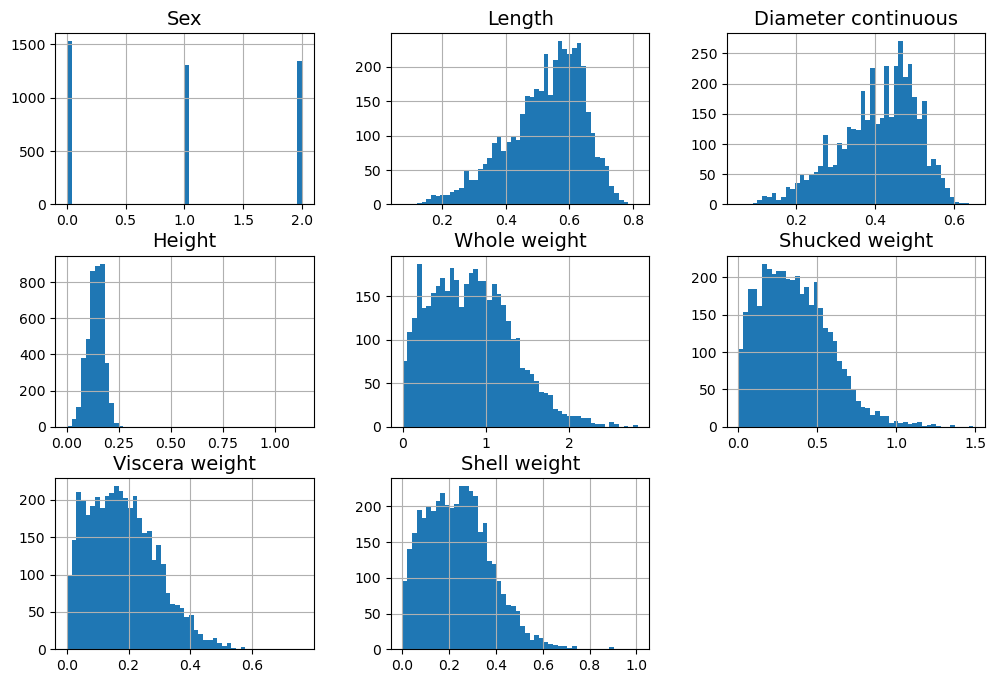

In [34]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

ab_data.drop('Rings', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

In [35]:
# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
ab_train_X, ab_test_X, ab_train_y, ab_test_y = train_test_split(ab_data.drop('Rings', axis=1), ab_data['Rings'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_2 = MinMaxScaler(feature_range=(0,1))

ab_train_X = scaler_func.fit_transform(ab_train_X)
ab_test_X = scaler_func.transform(ab_test_X)

#Transform back into a pd dataframe
feature_cols = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight"]
ab_train_X=pd.DataFrame(ab_train_X, columns=feature_cols)
ab_test_X=pd.DataFrame(ab_test_X, columns=feature_cols)

## 3.1 Tuning Max_Depth

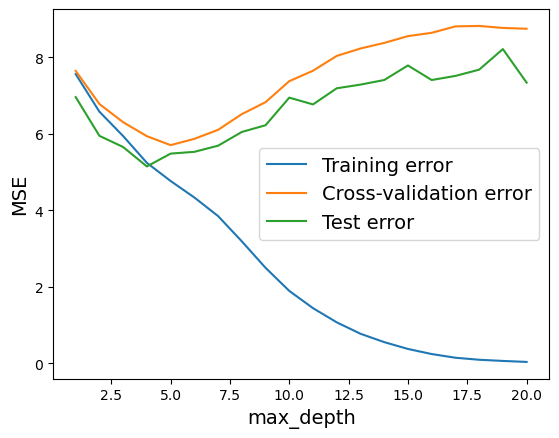

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Set the range of max_depth values to test
max_depths = range(1, 21)

# Initialize empty lists to store the errors
train_errors = []
cv_errors = []
test_errors = []

# Loop through each value of max_depth and fit a decision tree regression model
for max_depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
    cv_error = -1 * cv_scores.mean()
    cv_errors.append(cv_error)
    
    # Fit the model on the training data and evaluate its performance on the training set
    dt.fit(ab_train_X, ab_train_y)
    train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
    train_errors.append(train_error)
    
    # Evaluate the model on the test data
    test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
    test_errors.append(test_error)

# Plot the errors as a function of max_depth
plt.plot(max_depths, train_errors, label='Training error')
plt.plot(max_depths, cv_errors, label='Cross-validation error')
plt.plot(max_depths, test_errors, label='Test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3.2 Tuning Min_Samples_Leaf

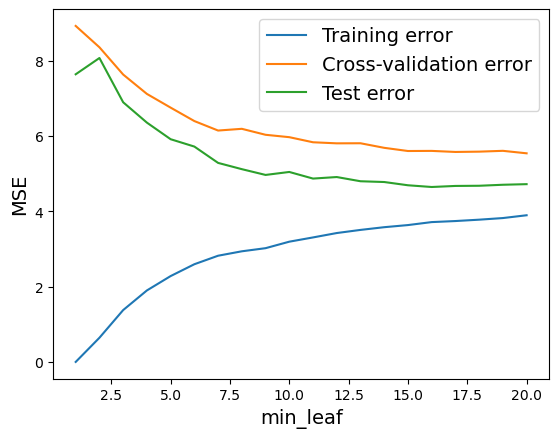

In [37]:
# Set the range of min_leaf values to test
min_leafs = range(1, 21)

# Initialize empty lists to store the errors
train_errors = []
cv_errors = []
test_errors = []

# Loop through each value of min_leaf and fit a decision tree regression model
for min_leaf in min_leafs:
    dt = DecisionTreeRegressor(min_samples_leaf=min_leaf)
    
    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
    cv_error = -1 * cv_scores.mean()
    cv_errors.append(cv_error)
    
    # Fit the model on the training data and evaluate its performance on the training set
    dt.fit(ab_train_X, ab_train_y)
    train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
    train_errors.append(train_error)
    
    # Evaluate the model on the test data
    test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
    test_errors.append(test_error)

# Plot the errors as a function of min_leaf
plt.plot(min_leafs, train_errors, label='Training error')
plt.plot(min_leafs, cv_errors, label='Cross-validation error')
plt.plot(min_leafs, test_errors, label='Test error')
plt.xlabel('min_leaf')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3.3 Random Forest with 500 Estimators 

The following cell takes a very long time to run and has been commented out. The 4 hyperparameters have been chosen for this grid search using 3 fold cross validation and the best parameters have been found:

- booststrap: True
- max_depth: 16
- max_features: log2
- min_samples_leaf: 4

In [38]:
from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor()

# # Define the hyperparameters and their possible values for grid search
# param_grid = {
#     'max_depth': range(1, 21),
#     'min_samples_leaf': range(1, 21),
#     'max_features': [1.0, 'sqrt', 'log2'],
#     'bootstrap': [True, False]  
# }

# # Create a grid search object with 3-fold cross-validation
# grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# # Fit the grid search object to the training data
# grid_search.fit(ab_train_X, ab_train_y)

# # Print the best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)

# # Print the best cross-validation score
# print("Best cross-validation score:", grid_search.best_score_)

In [39]:
# Create a random forest regressor with best hyperparameters
forest = RandomForestRegressor(max_depth=16, bootstrap=True, max_features='log2', min_samples_leaf=4)
# fit regressor to training data
forest.fit(ab_train_X, ab_train_y)
# predict on test set
y_pred = forest.predict(ab_test_X)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.015167996482551


## 3.4 Feature Selection

- Use select from model
- Use get support to obtain feature mask
    - See that the sex col is false i.e. it is under the 0.05 importance threshold
- Drop that col
- RMSE goes up?

In [40]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(forest, prefit=True, threshold=0.05)
print("The feature mask is:", selector.get_support())

ab_train_X_1 = ab_train_X.drop('Sex', axis=1)
ab_test_X_1 = ab_test_X.drop('Sex', axis=1)

The feature mask is: [False  True  True  True  True  True  True  True]


In [41]:
# Create a random forest regressor with best hyperparameters
forest_1 = RandomForestRegressor(max_depth=16, bootstrap=True, max_features='log2', min_samples_leaf=4)
# fit regressor to training data
forest_1.fit(ab_train_X_1, ab_train_y)
# predict on test set
y_pred = forest_1.predict(ab_test_X_1)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.0249759821985425


## 3.5 Bagging Regressor

In [42]:
from sklearn.ensemble import BaggingRegressor
#experiment with hyperparameters from task sheet
bag = BaggingRegressor(SVR(kernel='rbf',gamma='auto',C=20),n_estimators=500,n_jobs=-1)

bag.fit(ab_train_X, ab_train_y)

# predict on the test set
y_pred = bag.predict(ab_test_X)
np.rint(y_pred)

bag_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', bag_rmse)

The RMSE on the test set is: 2.04050155955306
